# Modelado en Series de Tiempo

## Importación de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.cm as cm
from datetime import datetime
from pandas.plotting import lag_plot

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import re

import warnings
warnings.simplefilter('ignore')

In [2]:
def seasonal_decompose(df,column,model, period):
    
    res = sm.tsa.seasonal_decompose(
        df[column], model=model, period=period
        )
    
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12, 18))
    
    ax1.set_title('Comportamiento del universo')
    df[column].plot(ax=ax1, color='red')
    ax1.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax1.set_ylabel('Original')
    
    res.trend.plot(ax=ax2)
    ax2.set_title('Tendencia')
    ax2.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax2.set_ylabel('Tendencia')
    
    res.seasonal.plot(ax=ax3)
    ax3.set_title('Variaciones Estacionales')
    ax3.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax3.set_ylabel('Variaciones Estacionales')
    
    res.resid.plot(ax=ax4)
    ax4.set_title('Variaciones Irregulares')
    ax4.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax4.set_ylabel('Variaciones Irregulares')
    
    plt.tight_layout()
    plt.show()

Cargamos la base de datos de licencias médicas

In [3]:
url = 'https://raw.githubusercontent.com/MentoriaDiploDatos/Presentacion/main/data.csv'
df = pd.read_csv(url, sep=';')
df.head(3)

,numero_licencia,fecha_creacion,dispositivo_acceso,dias_solicitados,fecha_inicio,fecha_fin,diagnostico,id_diagnostico,id_usuario,fecha_nacimiento,genero,tipo_licencia,estado_civil,dias_aprobados,decision_medica,id_auditor,motivo_rechazo,categoria_diagnostico
0,1,2021-01-01 00:10:10.418,APP,2.0,2021-01-01,2021-01-01,EFECTOS ADVERSOS DE VACUNAS VIRALES,NaN,15508,1979-11-28,FEMALE,Médica,OTHER,2.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
1,105,2021-01-02 14:14:20.330,APP,2.0,2021-01-02,2021-01-03,EFECTOS ADVERSOS DE VACUNAS VIRALES,NaN,15508,1979-11-08,FEMALE,Médica,OTHER,2.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
2,113806,2021-08-26 09:32:09.396,APP,1.0,2021-08-26,2021-08-26,COLELITIASIS,NaN,3661,1980-10-25,FEMALE,Médica,SINGLE,0.0,RECHAZAR,14721.0,NaN,NaN


## Creando la base de datos con la cual se va a modelar

Para el ejemplo vamos a trabajar unicamente con las licencias aprobadas y que tienen como diagnóstico COVID.

In [4]:
aprobadas= df.loc[df["decision_medica"]!= "RECHAZAR"]

In [5]:
covid_aprobadas= aprobadas[aprobadas['diagnostico']\
                      .apply(lambda x: bool(re.search('(Covid|covid|COVID|ESTRECHO)', str(x))))]

Asignamos el tipo de dato _datetime_ a `fecha_creacion`

In [6]:
covid_aprobadas['fecha_creacion'] = pd.to_datetime(df['fecha_creacion']).dt.date
covid_aprobadas['fecha_creacion'] = covid_aprobadas['fecha_creacion'].apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d'))

Se realiza un _resample_ semanal

In [7]:
covid_aprobadas["datetime_monday_week"] = covid_aprobadas["fecha_creacion"].dt.to_period('W').dt.start_time

In [8]:
covid_aprobadas.set_index('fecha_creacion', inplace=True)

In [9]:
df_week= covid_aprobadas.groupby("datetime_monday_week").count().reset_index()

A continuación se muestra la variación de las licencias agrupadas semanalmente a lo largo del período 2021-2022

<AxesSubplot:>

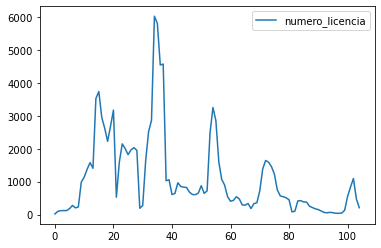

In [11]:
df_week[['numero_licencia']].plot()

In [12]:
df_week.set_index("datetime_monday_week", inplace=True)

## Descomposición de la serie temporal

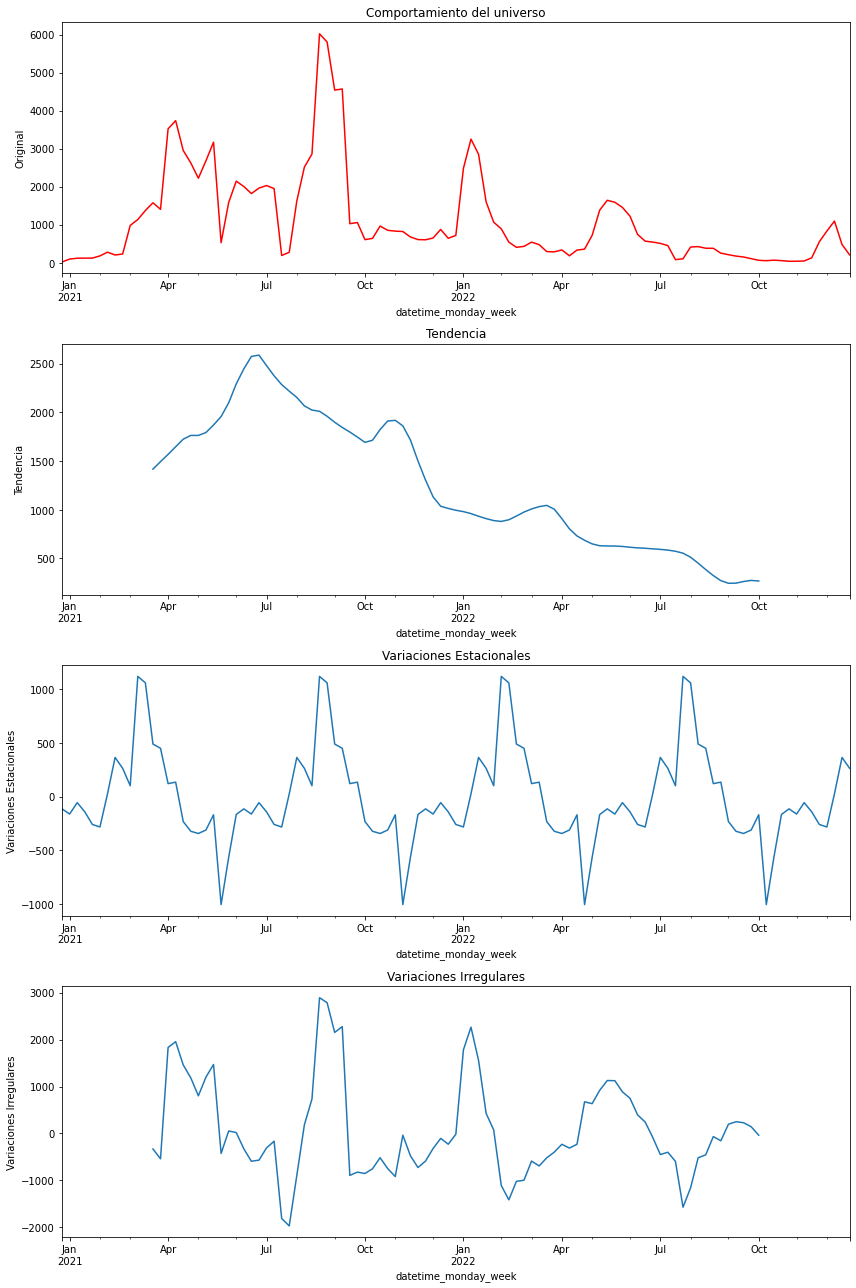

In [13]:
seasonal_decompose(df_week,
                   'numero_licencia', 
                   model='additive',
                   period=24)

## ACF y PACF

In [15]:
df_covid = df_week.groupby("datetime_monday_week")[['numero_licencia']].sum()

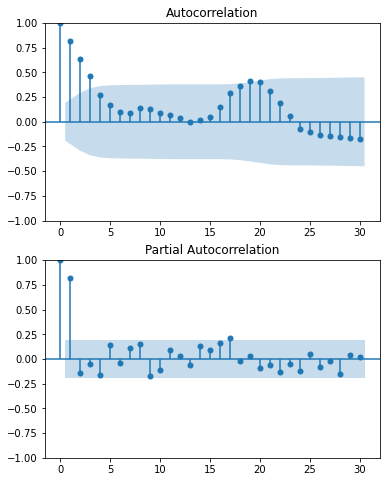

In [16]:
fig, axes = plt.subplots(2,1,figsize=(6,8))

plot_acf(df_covid, lags=30,ax=axes[0]);
plot_pacf(df_covid, lags=30,ax=axes[1]);

## Modelando ARIMA Seasonal con tendencia

\begin{align*}
\LARGE \mathbf{ARIMA} (p, d, q) {x} (P, D, Q)S
\end{align*}

In [17]:
auto_arima(df_covid,
           start_p=0, 
           start_q=0, 
           max_p=4, 
           max_q=4, 
           seasonal=True, 
           trace=1, 
           m=24).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=1663.926, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=1667.062, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=1663.779, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=1663.830, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=1665.065, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=1668.867, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=1665.772, Time=0.77 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=1666.214, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=1663.849, Time=0.23 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=1667.729, Time=2.07 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=1661.944, Time=0.17 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=1663.934, Time=0.55 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=1661.995, Time=0.15 sec
 ARIMA(0,1,0)(2,0,1)[24] intercept   : AIC=1665.842, Time=1.75 sec
 ARIMA(0,1,1)(1,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 24)   Log Likelihood                -827.972
Date:                            Tue, 08 Aug 2023   AIC                           1659.944
Time:                                    15:44:46   BIC                           1665.233
Sample:                                12-28-2020   HQIC                          1662.087
                                     - 12-26-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24      -0.2665      0.067     -3.980      0.000      -0.398      -0.135
sigma2      4.738e+05   3.37e+04     14.050      0.000    4.08e+05     5.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               309.54
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
train_data  = df_covid.iloc[0:75]

In [105]:
test_data = df_covid.iloc[75:]

In [109]:
order = (0,1,0)
seasonal_order= (1,0,0,24)
start=len(train_data)
end=len(train_data)+len(test_data)-1

results = SARIMAX(train_data,
                  order=order,
                  seasonal_order=seasonal_order).fit()
predictions_sarima = results.predict(start=start, 
                                     end=end,
                                     dynamic=False, 
                                     typ='levels').rename('SARIMA {}{} Predictions'.format(order,seasonal_order))

In [110]:
 print("Error absoluto medio: {}".format(mean_absolute_error(test_data, predictions_sarima)))
print("Error cuadrático medio: {}".format(np.sqrt(mean_squared_error(test_data, predictions_sarima))))

Error absoluto medio: 1061.535322375955
Error cuadrático medio: 1131.4178027117096


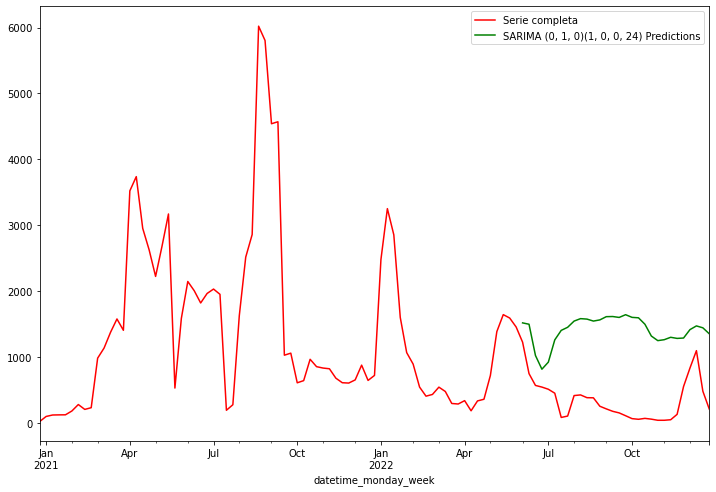

In [111]:
df_covid.numero_licencia.plot(legend=True, 
                              label='Serie completa', 
                              color='red',
                              figsize=(12,8)).ticklabel_format(style='plain', axis='y')

predictions_sarima.plot(legend=True,
                        color='green', 
                        figsize=(12,8))
plt.show()

## Exponential Smoothing

In [34]:
#Holt Winter’s Exponential Smoothing

trend='add'
seasonal='mul'
seasonal_periods=24

model = ExponentialSmoothing(train_data,
                             trend=trend,#se especifica la tendencia
                             damped_trend=True,#tendencia amortiguada
                             seasonal=seasonal, #tipo de estacionalidad
                             seasonal_periods=seasonal_periods,#numero de periodos de in ciclo estacional
                             initialization_method="estimated").fit()
exponential_predictions = model.forecast(len(test_data)).rename('Exponential Smoothing Predictions')

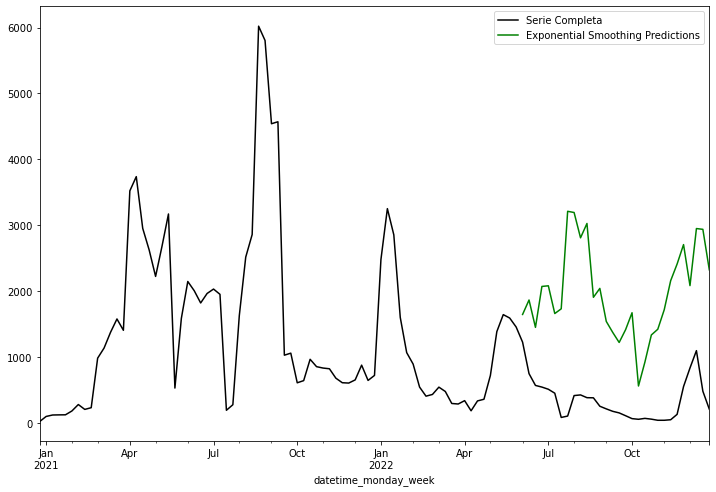

In [35]:
df_covid.numero_licencia.plot(legend=True, 
                              label='Serie Completa', 
                              color='black',
                              figsize=(12,8)).ticklabel_format(style='plain', axis='y')

exponential_predictions.plot(legend=True, 
                             color='green',
                             figsize=(12,8))
plt.show()

In [36]:
print("Error absoluto medio: {}".format(mean_absolute_error(test_data, exponential_predictions)))
print("Error cuadrático medio: {}".format(np.sqrt(mean_squared_error(test_data, exponential_predictions))))

Error absoluto medio: 1634.8122529952695
Error cuadrático medio: 1756.8541390503697


## Pronósticos

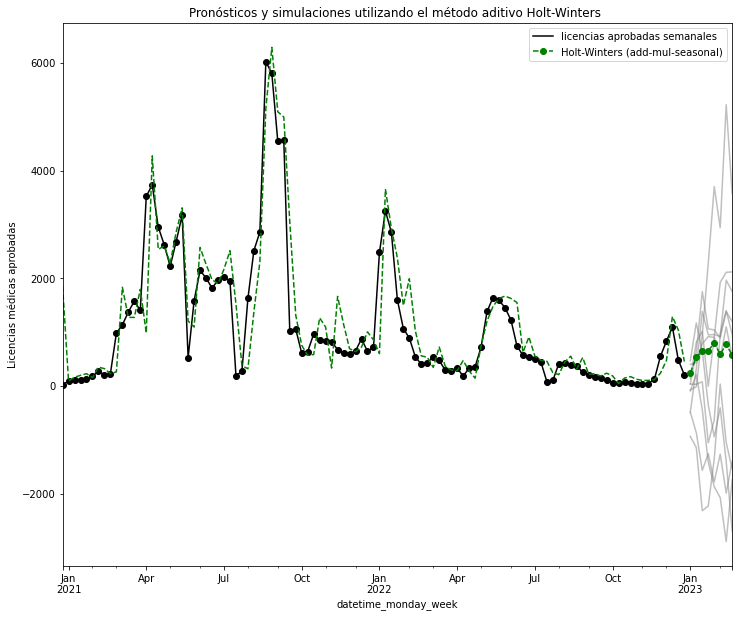

In [102]:
model_total = ExponentialSmoothing(
    df_covid,
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
    
).fit()

simulations = model_total.simulate(8, 
                             repetitions=10, 
                             error="add",
                             random_state=15)

ax = df_covid.plot(
    figsize=(12, 10),
    marker="o",
    color="black",
    title="Pronósticos y simulaciones utilizando el método aditivo Holt-Winters ",
    legend=False
)
ax.set_ylabel("Licencias médicas aprobadas")
ax.legend(["licencias aprobadas semanales"])

model_total.fittedvalues.plot(ax=ax, 
                        style="--", 
                        color="green")
simulations.plot(ax=ax, 
                 style="-",
                 alpha=0.5, 
                 color="grey", 
                 legend=False)

model_total.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, 
                                                               style="--", 
                                                               marker="o", 
                                                               color="green", 
                                                               legend=True)
plt.show()